## Assignment 7B
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### In this assignment we are going to use CIFAR10 dataset where we will have different images e.g. Airplane, Automobile, Bird, Cat etc with resolution of 32 x 32 and we will try to implement eNAS model as below:

![alt text](https://github.com/santuhazra1/TSAI_EVA_PHASE_1/blob/master/Session%207/Images/enasdiscoverednetwork.png?raw=true)

### So to achieve this goal lets first import keras library and  import all pakages and functions from keras with which we are going to build the CNN model

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,SeparableConv2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Input,Reshape,Add,Lambda
from keras.layers import concatenate
from keras.models import Model
from tensorflow import space_to_depth

### Now we are going to load the pre-shuffled CIFAR10 data from keras. Out of total 60k data we have 50k different class image as train data and 10k image as test data which is autometically predefined in mnist dataset. So here we have total 10 different classes of images as: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [3]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_rows, img_cols, img_channels =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))
print(train_features.shape)
print(test_features.shape)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Now let's look into some images. Here we are going to pick one image from each class randomly to see how it looks:

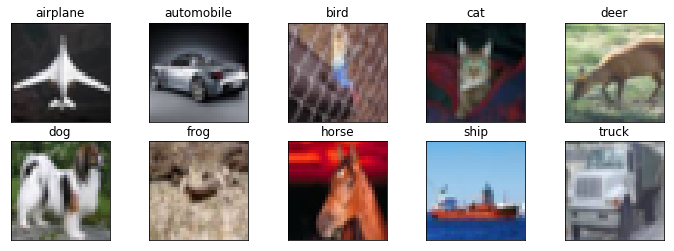

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(12,4))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### Now here we are going to create a function which is going to plot our train and test model accuracy and losses with respect epochs.

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Also, here we have created one more function which is going to give us actual  test accuracy from model and test data:

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### Now, lets scale the test and train data and change labels from 1-dimentional class matrix to 10 dimentional class matrix so that we can predict out of 10 class.

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Now let's build our eNAS model using functional API:

In [0]:
def resize(input_layer,target_layer):
  # Import currently required to make Lambda work.
  #See: https://github.com/fchollet/keras/issues/5088#issuecomment-273851273
  import tensorflow as tf
  blocksize = input_layer.get_shape().as_list()[1]/target_layer.get_shape().as_list()[1]
  output = Lambda(lambda x: tf.space_to_depth(x, block_size=blocksize))(input_layer)
  return output

In [9]:
input_layer = Input(shape=(32,32,3))

sep_conv_layer_1 = SeparableConv2D(30, 5, 5, activation='relu', border_mode='same', name='sep_conv_layer_1')(input_layer)
batch_norm_layer1 = BatchNormalization()(sep_conv_layer_1)
dropout_layer1 = Dropout(0.15)(batch_norm_layer1)

conv_layer_2 = Convolution2D(60, 5, 5, activation='relu', border_mode='same', name='conv_layer_2')(dropout_layer1)
batch_norm_layer2 = BatchNormalization()(conv_layer_2)
dropout_layer2 = Dropout(0.15)(batch_norm_layer2)

conv_layer_3 = Convolution2D(90, 5, 5, activation='relu', border_mode='same', name='conv_layer_3')(dropout_layer2)
batch_norm_layer3 = BatchNormalization()(conv_layer_3)
dropout_layer3 = Dropout(0.15)(batch_norm_layer3)

merge1 = concatenate([dropout_layer3, dropout_layer1])

conv_1x1_1 = Convolution2D(90, 1, 1, activation='relu', border_mode='same', name='conv_1x1_1')(merge1)
batch_norm_1x1_1 = BatchNormalization()(conv_1x1_1)

sep_conv_layer_4 = SeparableConv2D(120, 5, 5, activation='relu', border_mode='same', name='sep_conv_layer_4')(batch_norm_1x1_1)
batch_norm_layer4 = BatchNormalization()(sep_conv_layer_4)
dropout_layer4 = Dropout(0.15)(batch_norm_layer4)

merge2 = concatenate([dropout_layer4, dropout_layer1])

conv_1x1_2 = Convolution2D(30, 1, 1, activation='relu', border_mode='same', name='conv_1x1_2')(merge2)
batch_norm_1x1_2 = BatchNormalization()(conv_1x1_2)

maxpool1 = MaxPooling2D(pool_size=(2, 2))(batch_norm_1x1_2)

sep_conv_layer_5 = SeparableConv2D(30, 3, 3, activation='relu', border_mode='same', name='sep_conv_layer_5')(maxpool1)
batch_norm_layer5 = BatchNormalization()(sep_conv_layer_5)
dropout_layer5 = Dropout(0.15)(batch_norm_layer5)

merge3 = concatenate([dropout_layer5, resize(dropout_layer4,maxpool1), resize(dropout_layer1,maxpool1)])

conv_1x1_3 = Convolution2D(30, 1, 1, activation='relu', border_mode='same', name='conv_1x1_3')(merge3)
batch_norm_1x1_3 = BatchNormalization()(conv_1x1_3)

conv_layer_6 = Convolution2D(60, 5, 5, activation='relu', border_mode='same', name='conv_layer_6')(batch_norm_1x1_3)
batch_norm_layer6 = BatchNormalization()(conv_layer_6)
dropout_layer6 = Dropout(0.15)(batch_norm_layer6)

merge4 = concatenate([dropout_layer6, dropout_layer5, resize(dropout_layer4,maxpool1), resize(dropout_layer3,maxpool1)])

conv_1x1_4 = Convolution2D(60, 1, 1, activation='relu', border_mode='same', name='conv_1x1_4')(merge4)
batch_norm_1x1_4 = BatchNormalization()(conv_1x1_4)

sep_conv_layer_7 = SeparableConv2D(90, 3, 3, activation='relu', border_mode='same', name='sep_conv_layer_7')(batch_norm_1x1_4)
batch_norm_layer7 = BatchNormalization()(sep_conv_layer_7)
dropout_layer7 = Dropout(0.15)(batch_norm_layer7)

merge5 = concatenate([dropout_layer7, dropout_layer6, dropout_layer5, resize(dropout_layer4,maxpool1), resize(dropout_layer3,maxpool1), resize(dropout_layer1,maxpool1)])

conv_1x1_5 = Convolution2D(90, 1, 1, activation='relu', border_mode='same', name='conv_1x1_5')(merge5)
batch_norm_1x1_5 = BatchNormalization()(conv_1x1_5)

sep_conv_layer_8 = SeparableConv2D(120, 5, 5, activation='relu', border_mode='same', name='sep_conv_layer_8')(batch_norm_1x1_5)
batch_norm_layer8 = BatchNormalization()(sep_conv_layer_8)
dropout_layer8 = Dropout(0.15)(batch_norm_layer8)

merge6 = concatenate([dropout_layer8, dropout_layer7, dropout_layer5, resize(dropout_layer4,maxpool1), resize(dropout_layer1,maxpool1)])

conv_1x1_6 = Convolution2D(30, 1, 1, activation='relu', border_mode='same', name='conv_1x1_6')(merge6)
batch_norm_1x1_6 = BatchNormalization()(conv_1x1_6)

maxpool2 = MaxPooling2D(pool_size=(2, 2))(batch_norm_1x1_6)

merge7 = concatenate([maxpool2, resize(dropout_layer6,maxpool2)])

conv_1x1_7 = Convolution2D(30, 1, 1, activation='relu', border_mode='same', name='conv_1x1_7')(merge7)
batch_norm_1x1_7 = BatchNormalization()(conv_1x1_7)

conv_layer_9 = Convolution2D(30, 5, 5, activation='relu', border_mode='same', name='conv_layer_9')(batch_norm_1x1_7)
batch_norm_layer9 = BatchNormalization()(conv_layer_9)
dropout_layer9 = Dropout(0.15)(batch_norm_layer9)

merge8 = concatenate([dropout_layer9, resize(dropout_layer7,maxpool2), resize(dropout_layer4,maxpool2), resize(dropout_layer2,maxpool2)])

conv_1x1_8 = Convolution2D(30, 1, 1, activation='relu', border_mode='same', name='conv_1x1_8')(merge8)
batch_norm_1x1_8 = BatchNormalization()(conv_1x1_8)

sep_conv_layer_10 = SeparableConv2D(60, 5, 5, activation='relu', border_mode='same', name='sep_conv_layer_10')(batch_norm_1x1_8)
batch_norm_layer10 = BatchNormalization()(sep_conv_layer_10)
dropout_layer10 = Dropout(0.15)(batch_norm_layer10)

merge9 = concatenate([dropout_layer10, dropout_layer9, resize(dropout_layer5,maxpool2), resize(dropout_layer3,maxpool2), resize(dropout_layer2,maxpool2)])

conv_1x1_9 = Convolution2D(60, 1, 1, activation='relu', border_mode='same', name='conv_1x1_9')(merge9)
batch_norm_1x1_9 = BatchNormalization()(conv_1x1_9)

conv_layer_11 = Convolution2D(90, 3, 3, activation='relu', border_mode='same', name='conv_layer_11')(batch_norm_1x1_9)
batch_norm_layer11 = BatchNormalization()(conv_layer_11)
dropout_layer11 = Dropout(0.15)(batch_norm_layer11)

merge10 = concatenate([dropout_layer11, dropout_layer10, resize(dropout_layer7,maxpool2), resize(dropout_layer5,maxpool2), resize(dropout_layer4,maxpool2), resize(dropout_layer3,maxpool2), resize(dropout_layer1,maxpool2)])

conv_1x1_10 = Convolution2D(90, 1, 1, activation='relu', border_mode='same', name='conv_1x1_10')(merge10)
batch_norm_1x1_10 = BatchNormalization()(conv_1x1_10)

sep_conv_layer_12 = SeparableConv2D(120, 5, 5, activation='relu', border_mode='same', name='sep_conv_layer_12')(batch_norm_1x1_10)
batch_norm_layer12 = BatchNormalization()(sep_conv_layer_10)
dropout_layer12 = Dropout(0.15)(batch_norm_layer12)

merge11 = concatenate([dropout_layer12, dropout_layer10, resize(dropout_layer7,maxpool2), resize(dropout_layer4,maxpool2)])

conv_1x1_11 = Convolution2D(10, 1, 1, activation='relu', name='conv_1x1_11')(merge11)
conv_layer_14 = Convolution2D(10, 8, name='conv_layer_14')(conv_1x1_11)

flat1 = Flatten()(conv_layer_14)
output = Activation('softmax')(flat1)

model = Model(inputs=input_layer, outputs=output)

W0615 07:52:12.507511 139967263074176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 07:52:12.544997 139967263074176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `SeparableConv2D` call to the Keras 2 API: `SeparableConv2D(30, (5, 5), activation="relu", name="sep_conv_layer_1", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0615 07:52:12.553693 139967263074176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.rando

### Now let's look at the model summary, Here we can see we have total of 500k parameters to train. Now let's see how this model is going to perform

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
sep_conv_layer_1 (SeparableConv (None, 32, 32, 30)   195         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 30)   120         sep_conv_layer_1[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 32, 32, 30)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_layer

### Now we are going to run this model for 50 epochs and let's check what training accuracy we are going to get:

In [11]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])

W0615 07:52:42.051164 139967263074176 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_s

Epoch 1/100


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '



Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
195/195 [==============================] - 73s 374ms/step - loss: 1.5715 - acc: 0.4359 - val_loss: 1.4619 - val_acc: 0.4936
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
195/195 [==============================] - 64s 328ms/step - loss: 1.1305 - acc: 0.6011 - val_loss: 1.2119 - val_acc: 0.5826
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
195/195 [==============================] - 64s 328ms/step - loss: 0.9236 - acc: 0.6757 - val_loss: 1.0052 - val_acc: 0.6546
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
195/195 [==============================] - 65s 331ms/step - loss: 0.7952 - acc: 0.7195 - val_loss: 0.9462 - val_acc: 0.6804
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.0013181019.
195/195 [==============================] - 65s 333ms/step - loss: 0.6917 - acc: 0.7565 -

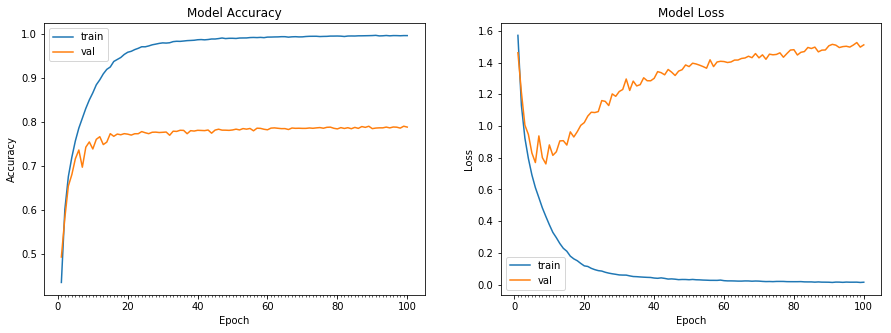

Best Accuracy on test data is: 78.80


In [12]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False,
                             featurewise_center=True, featurewise_std_normalization=True)

datagen_test = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
iterator_test = datagen_test.flow(test_features, test_labels, batch_size=len(test_features), shuffle=False)
test_features_2, test_labels_2 = iterator_test.next()

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen_train.flow(train_features, train_labels, batch_size = 256),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features_2, test_labels_2), verbose=1,
                                 callbacks=[LearningRateScheduler(scheduler, verbose=1)])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Best Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

### So, in the above model we can see that after implementing eNAS in CIFAR10 we have got best validation accuracy 79%